# Multiple Regression

In this notebook, we will learn:

- What is a multiple regression model
- How to run a multiple regression
- What are the assumptions of multiple regression and how do we verify them
- How to make a correlation matrix
- How to examine the variance inflation factors 
- How to examine the residuals and the standardized residuals
- How to make and interpret a qqplot

In [1]:
from datascience import *
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from scipy import stats

import pandas as pd

# For statistics. Requires statsmodels 5.0 or more
import statsmodels.api as sm
import statsmodels.formula.api as smf

## This is the line that imports the command for multiple regression
## from statsmodels.formula.api import ols

# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm


baby = pd.read_csv("baby.csv")

births = Table.read_table('baby.csv')

In [2]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


## What is Multiple Regression?

Suppose you have a numeric response variable, call it $y$, that you think may be dependent upon several numeric predictor variables, say $x_1$, $x_2$, ..., $x_n$.  Then the multiple regression model is:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n$$


For example, using the `births` data set shown above, imagine we think that Birth Weight may be dependent upon the rest of the quantitative variables in the data set.  

$$ \hat{Birth\ Weight} = \beta_0 + \beta_1\cdot Gestational\ Days + \beta_2 \cdot Maternal\ Age + \beta_3 \cdot Maternal\ Height +\\ \beta_4\cdot Maternal\ Pregnancy\ Weight$$

### How do we perform the analysis in Python?

There are lots of different modules that offer a multiple regression function, or functions related to multiple regression.  We're going to use the `statsmodels` module.  




In [3]:
## Prepare the data in the necessary format over the next few lines

Height = births.column("Maternal Height")
Weight = births.column("Maternal Pregnancy Weight")
Baby_weight = births.column("Birth Weight")
Days = births.column("Gestational Days")
Age = births.column("Maternal Age")

## On the next two lines, only edit the names of the arrays and variables
model_data = pd.DataFrame({'Mom_Height': Height, 'Mom_Weight': Weight, "Days" : Days, "Age" : Age ,'Baby_Weight': Baby_weight})
model = smf.ols("Baby_Weight ~ Days + Age + Mom_Height + Mom_Weight", model_data).fit()


## Don't edit below here

# Print the summary
print(model.summary())

# Peform analysis of variance on fitted linear model
#anova_results = anova_lm(model)

#print('\nANOVA results')
#print(anova_results)


                            OLS Regression Results                            
Dep. Variable:            Baby_Weight   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     75.02
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           1.20e-56
Time:                        07:39:15   Log-Likelihood:                -4945.7
No. Observations:                1174   AIC:                             9901.
Df Residuals:                    1169   BIC:                             9927.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -85.5237     14.830     -5.767      0.0

The mothers Age is not statistically significant in this model.  We know this because the p-value is 0.158.  Let's remove Age from the model and re-run the model.  

In [4]:
## Prepare the data in the necessary format over the next few lines

Height = births.column("Maternal Height")
Weight = births.column("Maternal Pregnancy Weight")
Baby_weight = births.column("Birth Weight")
Days = births.column("Gestational Days")

## On the next two lines, only edit the names of the arrays and variables
model_data = pd.DataFrame({'Mom_Height': Height, 'Mom_Weight': Weight, "Days" : Days, "Age" : Age ,'Baby_Weight': Baby_weight})
model = smf.ols("Baby_Weight ~ Days + Mom_Height + Mom_Weight", model_data).fit()


## Don't edit below here

# Print the summary
print(model.summary())

# Peform analysis of variance on fitted linear model
#anova_results = anova_lm(model)

#print('\nANOVA results')
#print(anova_results)


                            OLS Regression Results                            
Dep. Variable:            Baby_Weight   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     99.28
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           2.96e-57
Time:                        07:39:15   Log-Likelihood:                -4946.7
No. Observations:                1174   AIC:                             9901.
Df Residuals:                    1170   BIC:                             9922.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -81.0294     14.491     -5.592      0.0

In [5]:
## This array just lists the coefficient of the model
## Useful for manually coding a prediction function

model._results.params

array([-8.10294174e+01,  4.53067478e-01,  1.00277623e+00,  7.63781691e-02])

Let's code the prediction function based on these coefficients and use it to predict the birth weight of a baby born on 270th day of pregnancy whose mother was 5'2" and weighed 135 lbs.

In [6]:
coeffs = model._results.params

def pred_baby_weight(d, h, w):
    return coeffs.item(0) + coeffs.item(1)*d + coeffs.item(2)*h + coeffs.item(3)*w 

pred_baby_weight(270, 62, 135)

113.78198095799976

## Wait

What's with the warning message at the end of the regression output, the one that mentioned "multicollinearity", what is that about?

Now that we've run the model, we must verify that it meets all the assumptions of multiple regression.  First, what are those assumptions?


1. **Independence between predictor variables (no multicollinearity)**

2. **Linear relationships between predictor and response**

3. **Normality of residuals (with constant variance)**

4. **Independence between observations (no autocorrelation)**

How to verify these:

1. **Independence between predictor variables (no multicollinearity)**

Create a correlation matrix for all the variables involved.  Also, look at the Variance Inflation Factors (VIF).  Any variable with a VIF above 10 is a problem.  

2. **Linear relationships**

Check the scatter plots

3. **Normality of residuals (with constant variance)**

Look at the so-called qqplot of the residuals.  When in doubt, try a test for normality.  

To evaluate the constant variance, plot the standardized residuals agains the predictors.  What we don't want to see is the vertical spread getting smaller or bigger as we scan left to right.  

4. **Independence between observations (no autocorrelation)**

This is usually verified by the method of data collection.  

Let's start by looking at some correlations.  

In [7]:
from scipy.stats import pearsonr as cor

cor(births.column("Birth Weight"), births.column("Maternal Pregnancy Weight"))

(0.1559232701870693, 7.887284473937041e-08)

In [8]:
cor(births.column("Birth Weight"), births.column("Maternal Height"))

(0.20370417718968034, 1.8383435395238618e-12)

In [9]:
cor(births.column("Birth Weight"), births.column("Gestational Days"))

(0.4075427933888511, 3.395225576846884e-48)

In [10]:
cor(births.column("Birth Weight"), births.column("Maternal Age"))

(0.026982911002929502, 0.3556335564112342)

In [11]:
## First, we have to put the data into a 2-dimensional array
new_births = np.array([births.column("Birth Weight"),
                       births.column("Maternal Height"), 
                       births.column("Maternal Pregnancy Weight"),
                       births.column("Gestational Days")])


# This command makes the correlation matrix
np.corrcoef(new_births)

array([[1.        , 0.20370418, 0.15592327, 0.40754279],
       [0.20370418, 1.        , 0.43528743, 0.0704699 ],
       [0.15592327, 0.43528743, 1.        , 0.02365494],
       [0.40754279, 0.0704699 , 0.02365494, 1.        ]])

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# just edit this to list the predictors, leave out the response
predictor_data = model_data[['Mom_Weight', 'Mom_Height', 'Days']]
  
# VIF dataframe
VIF_data = pd.DataFrame()
VIF_data["feature"] = predictor_data.columns
  
# calculating VIF for each feature
VIF_data["VIF"] = [variance_inflation_factor(predictor_data.values, i)
                          for i in range(len(predictor_data.columns))]
  
print(VIF_data)

      feature         VIF
0  Mom_Weight   47.185075
1  Mom_Height  294.536723
2        Days  224.895066


All three of these VIF's are above the threshold of 10, but the highest is Mom_Height, which means that this variable *probably* correlates with both of the other variables.  Let's continue with the assumption checking, but we already know we're probably going to have to revise this model. 


Moving on, we'll verify that each predictor has a linear relationship with the response by looking at the scatterplots.  



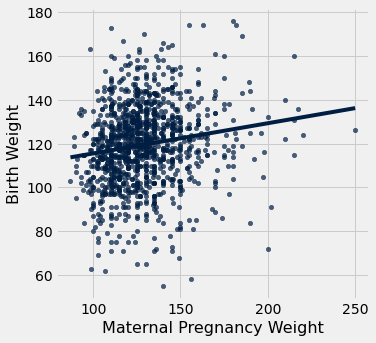

In [13]:
births.scatter("Maternal Pregnancy Weight", "Birth Weight", fit_line=True)

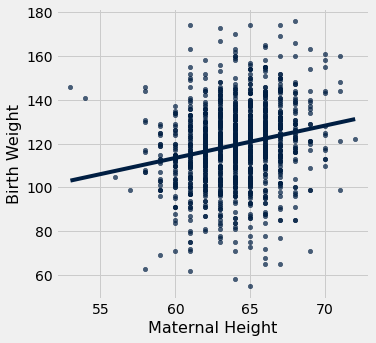

In [14]:
births.scatter("Maternal Height", "Birth Weight", fit_line=True)

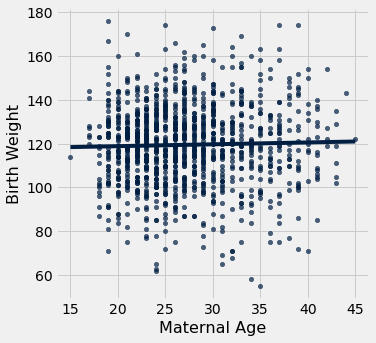

In [15]:
births.scatter("Maternal Age", "Birth Weight", fit_line=True)

## In the scatterplot below, we see that the mothers age and the babies
## weight really aren't closely related, so it was a good idea
## to drop Age from the model. 

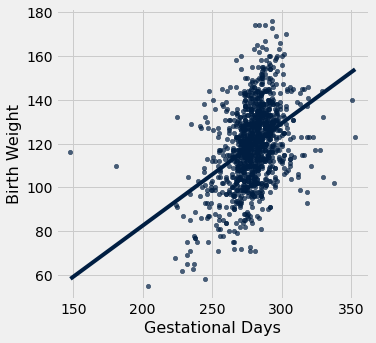

In [16]:
births.scatter("Gestational Days", "Birth Weight", fit_line=True)

Next, to check the normality of the residuals, we can use a Quantile-Quantile plot, known as a qqplot. 

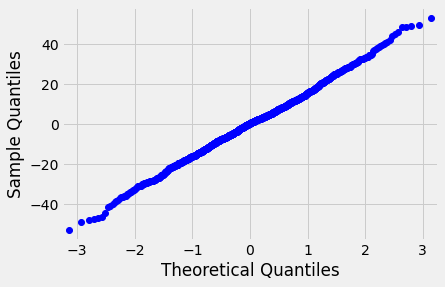

In [17]:
sm.qqplot(model.resid);

The closer to a diagonal line the qqplot displays, the closer to perfectly normal the residuals are.  In this case, these residuals look pretty good.  

If there's ever a qqplot that isn't clear, try a Shapiro-Wilk test for normality.  Here are the null and alternative hypothese for a Shapiro-Wilk test.  

$H_o:$  Data is normal

$H_a:$  Data is not normal

So a large $p$-value supports the belief that the data is normal.  

If we look at the results below, we do indeed see a large $p$-value.

In [18]:
stats.shapiro(model.resid)

(0.9980563521385193, 0.19163548946380615)

If the sample size exceeds 5000, the Shapiro-Wilk test is not recommended.  In which case, we might try an Anderson-Darling test instead, we'll cross that bridge when/if we come to it.  

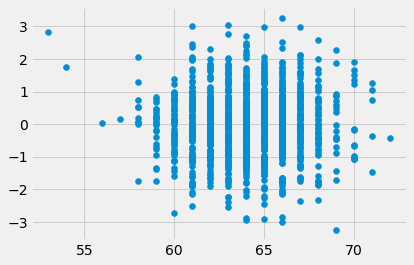

In [19]:
residuals = Baby_weight - model.predict()

std_res = (residuals - np.mean(residuals))/stats.tstd(residuals)

plots.scatter(Height, std_res);

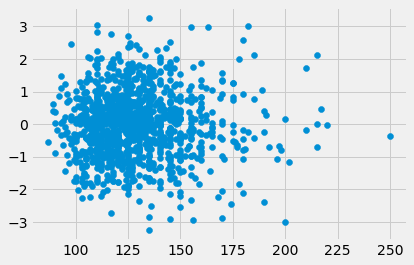

In [20]:
plots.scatter(Weight, std_res);

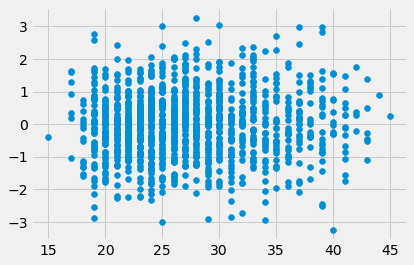

In [21]:
plots.scatter(Age, std_res);

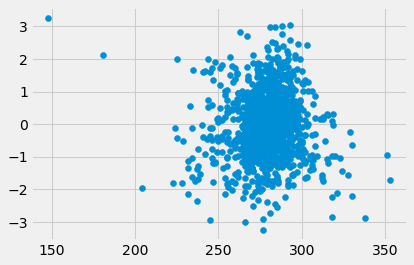

In [22]:
plots.scatter(Days, std_res);

The standardized residuals against the Height doesn't look so good.  Height also has one of the highest VIF's.  So let's eliminate that variable from the model and see what happens after that.  

In [23]:
## On the next two lines, only edit the names of the arrays and variables
model_data2 = pd.DataFrame({'Mom_Weight': Weight, "Days" : Days ,'Baby_Weight': Baby_weight})
model2 = smf.ols("Baby_Weight ~ Mom_Weight + Days", model_data2).fit()


## Don't edit below here

# Print the summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            Baby_Weight   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     135.1
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           1.59e-53
Time:                        07:39:16   Log-Likelihood:                -4958.0
No. Observations:                1174   AIC:                             9922.
Df Residuals:                    1171   BIC:                             9937.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.2709      8.881     -2.958      0.0

In [24]:
# just edit this to list the predictors, leave out the response
predictor_data = model_data2[['Mom_Weight', 'Days']]
  
# VIF dataframe
VIF_data = pd.DataFrame()
VIF_data["feature"] = predictor_data.columns
  
# calculating VIF for each feature
VIF_data["VIF"] = [variance_inflation_factor(predictor_data.values, i)
                          for i in range(len(predictor_data.columns))]
  
print(VIF_data)

new_births = np.array([births.column("Birth Weight"),
                       births.column("Maternal Pregnancy Weight"),
                       births.column("Gestational Days")])


# This command makes the correlation matrix
np.corrcoef(new_births)

      feature       VIF
0  Mom_Weight  35.54788
1        Days  35.54788


array([[1.        , 0.15592327, 0.40754279],
       [0.15592327, 1.        , 0.02365494],
       [0.40754279, 0.02365494, 1.        ]])

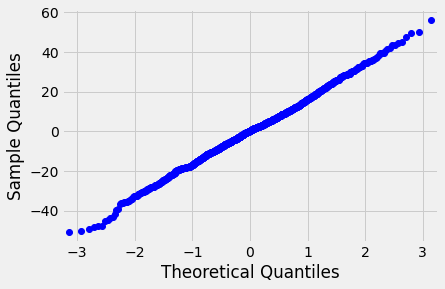

In [25]:
sm.qqplot(model2.resid);

In [26]:
stats.shapiro(model2.resid)

(0.9981358647346497, 0.22131392359733582)

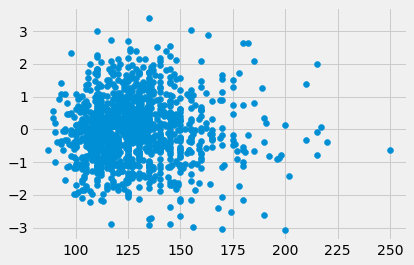

In [27]:
std_res = (model2.resid - np.mean(model2.resid))/stats.tstd(model2.resid)
plots.scatter(Weight, std_res);


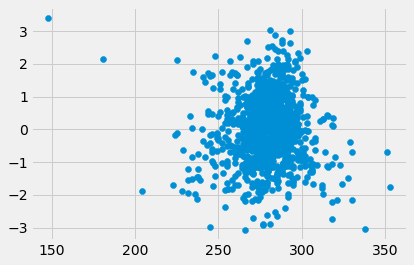

In [28]:
plots.scatter(Days, std_res);

Other than the fact that Mom_Weight and Days both have a VIF above 10, this model seem acceptable.  Besides, if we drop one more variable, we won't be doing multiple regression anymore.  So our final model is

$$\hat{Birth\ Weight} \approx -26.27 + 0.13\cdot Mom\ Weight + 0.46\cdot Days$$


If we're not sure if including both is okay, considering the VIF and 0.4 correlation between them, consider the scatterplot below.  The correlation is most likely being created by the low outliers under the otherwise horizontal blob.  

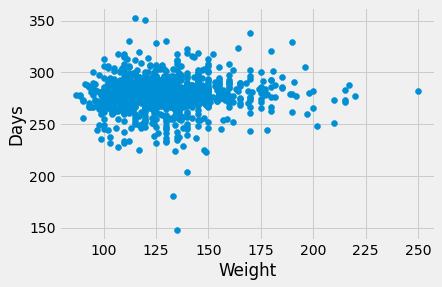

In [29]:
plots.scatter(Weight, Days)
plots.xlabel("Weight")
plots.ylabel("Days");

## Dummy Variables

Can we figure some way to include the variable for Smoking in the analysis?

Yes, we create a dummy variable for it.  Since Smoking is True/False, we only need one dummy variable, which must be coded using 0's and 1's.  

In general, if you have a factor variable with $k$ levels, you would need $k-1$ dummy variables to encode it in a way that would be useful in a multiple regression.  For now, let's just see how we do it with a variable with 2 levels.  

Normally, this would involve `if-else` statements, but we caught a lucky break this time.  Our factor variable is also already a Boolean, and we know that if we convert a Boolean to numeric False's come out as 0's and True's as 1's.  

In [30]:
def my_to_binary(x):
    ### converts an array of Trues and Falses to 1's and 0's ###
    return int(x)
    
births = births.with_column("Smoker Binary", births.apply(my_to_binary, "Maternal Smoker"))
births = births.where("Smoker Binary", are.contained_in(make_array(0,1)))

births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,Smoker Binary
120,284,27,62,100,False,0
113,282,33,64,135,False,0
128,279,28,64,115,True,1
108,282,23,67,125,True,1
136,286,25,62,93,False,0
138,244,33,62,178,False,0
132,245,23,65,140,False,0
120,289,25,62,125,False,0
143,299,30,66,136,True,1
140,351,27,68,120,False,0


In [31]:

Smoker = births.column("Smoker Binary")

model_data3 = pd.DataFrame({'Mom_Weight': Weight, "Days" : Days, "Smoker": Smoker ,'Baby_Weight': Baby_weight})
model3 = smf.ols("Baby_Weight ~ Mom_Weight + Days + Smoker", model_data3).fit()


## Don't edit below here

# Print the summary
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:            Baby_Weight   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           3.75e-67
Time:                        07:39:16   Log-Likelihood:                -4923.8
No. Observations:                1174   AIC:                             9856.
Df Residuals:                    1170   BIC:                             9876.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.6265      8.691     -2.028      0.0

## Interaction Terms

When we include a term in our model that is the product of two (or more) of the other variables already included in the model that is called an *interaction* term.  

Two way interactions are not rare, but three way, and higher, interactions supposedly are.  The Pausity of Effects Principle is that the majority of outcomes are predicted by several first order terms, and a few two-way interactions.  Higher interactions rarely impact the outcome.  

How do we run a model with an interaction term?  The model below demonstrates that.  

In [32]:
model_data3 = pd.DataFrame({'Mom_Weight': Weight, "Days" : Days, "Smoker": Smoker ,'Baby_Weight': Baby_weight})
model4 = smf.ols("Baby_Weight ~ Days + Smoker + Days*Smoker", model_data3).fit()

## Don't edit below here

# Print the summary
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:            Baby_Weight   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     113.2
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           2.41e-64
Time:                        07:39:17   Log-Likelihood:                -4930.3
No. Observations:                1174   AIC:                             9869.
Df Residuals:                    1170   BIC:                             9889.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      19.6396     10.291      1.908      

Now our model is 

$$\hat{Birth\ Weight} \approx 19.64 +0.37\cdot Days -72.69 \cdot Smoker + 0.23\cdot Days \cdot Smoker$$

This can be broken into two linear equations, one for the smokers and one for the non-smokers.  

For the non-smokers, we plug in a 0 for Smoker and get:

$$\hat{Birth\ Weight} \approx 19.64 +0.37\cdot Days$$

For the smokers, instead we plug in a 1 for Smoker and get:

$$\hat{Birth\ Weight} \approx 19.64 +0.37\cdot Days -72.69 \cdot 1 + 0.23\cdot Days \cdot 1= -53.05 + 0.60 \cdot Days$$


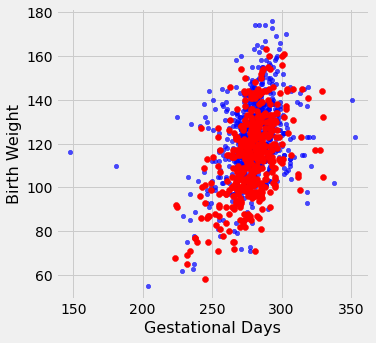

In [33]:
births.where("Smoker Binary", 0).scatter("Gestational Days", "Birth Weight", color = "blue")
plots.scatter(births.where("Smoker Binary", 1).column("Gestational Days"), 
              births.where("Smoker Binary", 1).column("Birth Weight"), color ="red");

In [38]:
0.37*make_array(150, 350)+19.64

array([ 75.14, 149.14])

In [37]:
.6*make_array(180, 350)-53.05

array([ 54.95, 156.95])

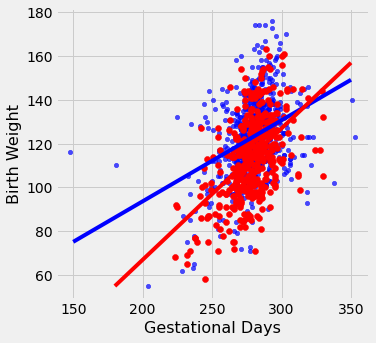

In [39]:
births.where("Smoker Binary", 0).scatter("Gestational Days", "Birth Weight", color = "blue")
plots.scatter(births.where("Smoker Binary", 1).column("Gestational Days"), 
              births.where("Smoker Binary", 1).column("Birth Weight"), color ="red")
plots.plot([150, 350], [75.14, 149.14], color = "blue", zorder = 6)
plots.plot([180, 350], [54.95, 156.95], color = "red", zorder = 7);